Let's create a more complex model that figures out what breed of pet is shown in each image.

We'll first assume we know nothing about the dataset.

In [1]:
from fastai.vision.all import *
from fastbook import *
path = untar_data(URLs.PETS)

Path.BASE_PATH = path
(path/"images").ls()[0]

Path('images/Siamese_125.jpg')

The code above shows us the format of the files in the dataset.

Each filename contains the pet breed _ number . file extension

We will use a regex expression to extract the breed from the file name and assign that as the label for its corresponding image.

In [2]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),                                 # NEW
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))   # NEW
dls = pets.dataloaders(path/"images")

There are two new lines:
- The first one crops full width or height of each individaul iamge before its copied to the GPU
- The second one randomizes crop (because of min_scale argument, RandomResizedCrop is used) and augments each image on the batch that is on the GPU

We need this because of Presizing - a way to do image augmentation designed to minimize data destruction and maintain good performance.

All images must have the same dimensions so they can collate into tensors passed to the GPU

We also want to minimze the numnber of distinct augmentation computations we perform.

So, we compose our augmentation transforms into fewer transforms and transform the images into uniform sizes.

Problem is that if we augment the data after resizing down then some augmentation transforms could intrdouce emtpy zones

So we do two things:
1. Resize the images to relatively large dimensions (dimensions significantly larger than targe training dimensions)
2. Compose all common augmentation operations into one, perform the combined operation on the GPU at the end of processing

To make sure we didn't screw anything up, lets use ths show_batch method to ensure everything is working as expected:

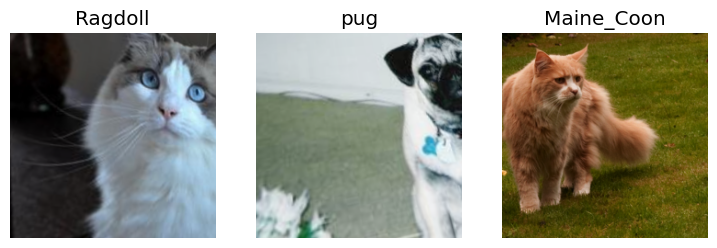

In [3]:
dls.show_batch(nrows=1, ncols=3)

In [4]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.530524,0.330600,0.101489,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.492832,0.281023,0.084574,00:16
1,0.330365,0.234156,0.072395,00:16


## THIS IS OUR BASE RESULTS

We haven't told which loss function this model should use.

fastai will default to using cross-entropy loss when we have image data and a categorical outcome.

## Cross-Entropy Loss

It is similar to the one we used before but has two benefits:
1. It works when our dependent variable (target) has more than two categories
2. It reults in faster and more reliable training

To better understand this, let's look at the actual data and activations that are seen by the loss function

### Viewing Activations and Labels

Looking at the activations (numbers outputted by linear/non-linear layers) of our model

We can use the one_batch method to get a batch of real data from DataLoaders:

In [5]:
x,y = dls.one_batch()

Let's see whats in the dependent variable for this mini-batch

In [6]:
y

TensorCategory([24,  1, 19, 18, 26, 29, 19,  2, 30, 29, 21, 16,  0, 15, 22, 24,  4, 14, 29, 34,  8, 25, 11, 32, 24, 36, 16, 21, 34, 31, 23, 29,  9, 19, 19, 29, 12, 34, 28, 31, 15,  9,  7, 18, 17,  6,
                25, 20, 20,  3, 22, 14, 24,  3, 31,  9, 22, 14, 33,  9, 22, 20, 17, 10], device='cuda:0')

Our batch size is 64, so we have 64 rows in the tensor.

Each row contains a single integer between 0 and 36, representing 37 possible pet breeds

We can view the predictions (the activations of the final layer of our neural network) using Learner.get_preds

In [7]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([6.2717e-09, 4.0621e-08, 9.4481e-07, 1.3088e-07, 1.8275e-07, 1.0386e-07, 2.1808e-06, 4.0724e-07, 9.6489e-07, 1.0217e-06, 3.7123e-08, 5.1820e-08, 3.7881e-09, 9.7354e-08, 1.6166e-08, 1.1245e-08,
        2.3752e-08, 4.7977e-07, 2.8527e-08, 6.3470e-08, 2.1339e-07, 1.4356e-07, 5.8440e-07, 7.1631e-08, 9.9987e-01, 1.5867e-07, 1.3915e-07, 2.4310e-07, 1.1693e-04, 1.5022e-06, 3.8172e-09, 1.2454e-06,
        1.2677e-06, 1.2901e-07, 1.8013e-07, 3.7950e-08, 3.6550e-07])

The actual predictions are 37 probabilities between 0 and 1, adding up to 1 in total

To turn these values into predictions, we use the softmax activation function.

### Softmax

In our classification model, we use the softmax activation function in the final layer to ensure that the activations are all between 0 and 1, and that they sum to 1.

Its similar to the sigmoid funciton.

We can apply this function to a single column of activations from a neural network, and get back a column between 0 and 1, so its super useful for the final layer

Let's say we have more categories in our target. We'll need more activations than just a single column: we need an activation per category.

We can create a neural net that predicts 3s and 7s that returns two activations (one for each class)

Let's use random numbers with a std of 2, assume 6 images and 2 categories (3, 7):

In [8]:
#hide
torch.random.manual_seed(42);
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We can't take sigmoid of this since we don't get rows that add to 1:

In [9]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

Last chapter our neural net created a single activation per image, which we passed through the sigmoid function.

That single activation represented the model's confidence that the input was a 3.

Instead of treating the target of this binary classification problem as a boolean value, lets set the target to represent likelihood of 3 and likelihood of 7.

So we just want to see which likelihood is bigger than the other.

To do this, we can just take the difference of these two functions and apply the sigmoid to it:

In [10]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

The probability of it being a 7 will just be the value subtracted from 1.

This is what softmax does and it works for more than two columns

So lets see if softmax returns the same values as sigmoid for the first column, and that those values subtracted from 1 are in the second column

In [11]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

It is! So softmax is the multi-category equivalent of sigmoid.

We use it any time we have more than two categories and the probablities of those categories must add to 1.

In practice this function does the following:
- Taking exponential ensures all numbers are positive
- Dividing by the sum ensures all numbers add up to 1
- Using exponential amplifies when one activation is slightly bigger than another

So really, the softmax function really tries to pick one class among the others -> ideal for training a classifier where each image has a definitive label

Softmax is the first part of the cross-entropy loss—the second part is log likelihood. 

### Log Likelihood

We need to extend the loss function wo work with more than just binary classification, it needs to be able to classify any number of categories

Our activations, after softmax, are between 0 and 1, and sum to 1 for each row in the batch of predictions

Our targets are integers between 0 and 36

Furthermore, cross-entropy loss generalizes our binary classification loss and alllows for more than one correct label per example but we don't want that in this case.

In the binary case, we used torch.where to select between inputs and 1-inputs

Now we have two columns containing the equivalent of inputs and 1-inputs

Since there is only one correct label per example, all we need to do is select the appropriate column

Let's say these are the labels for the synthetic 3s and 7s example:

In [12]:
targ = tensor([0,1,0,1,1,0])

These are the softmax activations:

In [13]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Then, for each item of targ we can use that to select the approprite column of sm_acts using tensor indexing

In [14]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

To make this easier to visualize, well put all the columns together in a table:

In [15]:
#hide_input
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide(axis="index")
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


Looking at this table, you can see that the `result` column can be calculated by taking the `targ` and `idx` columns as indices into the two-column matrix containing the `3` and `7` columns.

PyTorch provides a function that does the exact same thing as sm_acts[range(n), targ] called nn_loss
- Except it takes the negative because when applying the log afterward (we'll have negative numbers)

In [16]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [17]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

Doing loads of multiplication operations on negative numbers can cause a bunch of problems.

So were going to transform these probabilities into larger values so we can perform said mathematical operations.

We'll use the logarithm function for this:

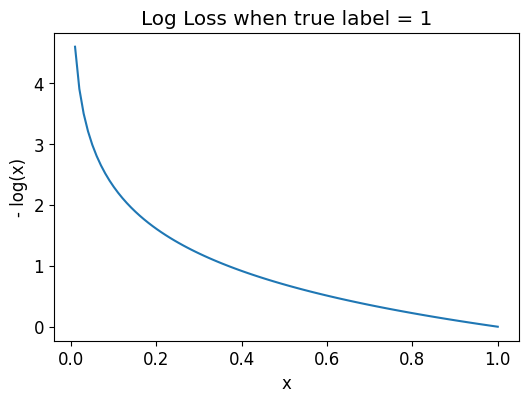

In [18]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

As the log of a number approaches negative infinity, the number approaches zero. Since this number reflects the predicted probability of the correct label, we want to take the negative of the log so that our loss function is correct

In [19]:
#hide_input
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide(axis="index")
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


We can see that wrong predictions with high confidence are penalized harshly because they are given a high loss value

### Negative Log Likelihood

Taking mean of negative log of our probabilities gives us the negative log likelihood loss (i.e. cross-entropy loss)

PyTorch's nll_loss assumes we have already taken the log of the softmax, so it doesn't do the logarithm for us

When we first take the softmax, and then the log likelihood of that, that combination is called *cross-entropy loss*. In PyTorch, this is available as `nn.CrossEntropyLoss` (which, in practice, actually does `log_softmax` and then `nll_loss`):

In [20]:
loss_func = nn.CrossEntropyLoss()
loss_func(acts, targ)

tensor(1.8045)

Can be re-written as:

In [21]:
F.cross_entropy(acts, targ)

tensor(1.8045)

By default, PyTorch will take the mean of the loss of all items which we can disable by specifing reduction='none'

In [22]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

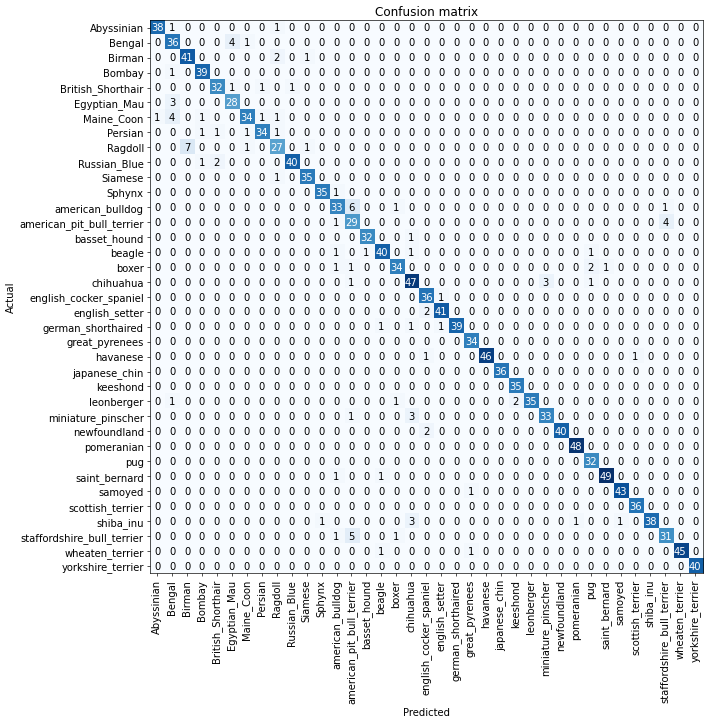

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', np.int64(7)),
 ('american_bulldog', 'american_pit_bull_terrier', np.int64(6)),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', np.int64(5))]

USING LEARNING RATE FINDER:

/home/one6ix/Desktop/fastai/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=devi

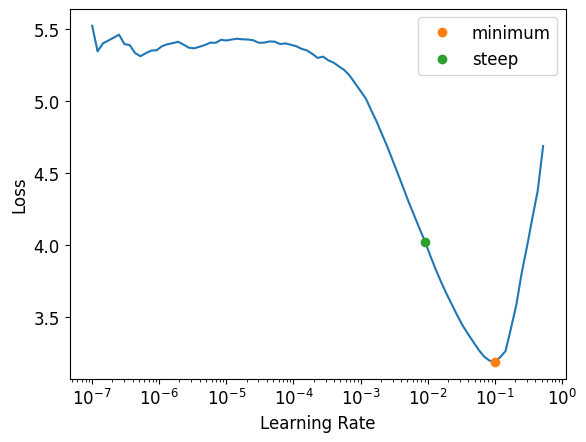

In [25]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [26]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 9.12e-03


We want to make usre that we have the right learning rate.

We'll use the learning rate finder for this:
- It will start with a super small learning rate on one batch and measure the loss
- Increase the learning rate by some amount and try it on another batch
- Continue until the loss gets worse, instead of better

We then select a learning rate a bit lower than the point where we've gone too far:
- Choose on order of magnitude less than where the minimum loss was achieved
- Choose the last point where the loss was clearly descending

We can see from the graph that in the range 1e-6 to 1e-3, nothing really happens

In this learning rate plot, 3e-3 seems to be the most appropriate.

In [27]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.333435,0.370477,0.118403,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.548403,0.370228,0.104195,00:16
1,0.312785,0.241453,0.076455,00:15


In [28]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.142492,0.324822,0.104871,00:12
1,0.562751,0.280780,0.083221,00:12
2,0.336956,0.224195,0.073748,00:12


In [29]:
learn.unfreeze()

SuggestedLRs(valley=5.248074739938602e-05)

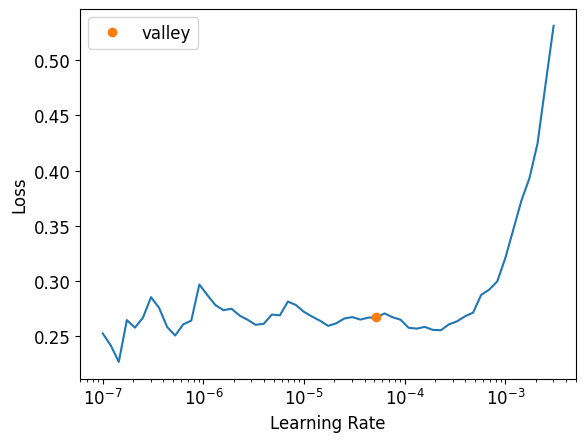

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.265556,0.217751,0.070365,00:16
1,0.235827,0.207096,0.069689,00:16
2,0.236751,0.210457,0.064953,00:16
3,0.208499,0.209270,0.070365,00:16
4,0.182852,0.206685,0.070365,00:15
5,0.188060,0.206450,0.069689,00:16


This has improved our model but there's more we can do.

The deepest layers of our pretrained model don't need as high a learning rate as the later ones.

So we'll use discriminative learning rates to make the learning rate gradually increase from the deepest layer to the last layer.

Python let's use use a slice object anywhere that a learning rate is expected.

So we'll set the learning rate for the deepest layer to 1e-6 and the learning rate of the last layer to 1e-4.

In [32]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.168460,0.341497,0.110284,00:12
1,0.535402,0.256863,0.084574,00:12
2,0.340761,0.221734,0.070365,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.271081,0.218415,0.069689,00:16
1,0.247316,0.214331,0.064953,00:16
2,0.244483,0.205668,0.064953,00:16
3,0.237777,0.208317,0.063599,00:16
4,0.196899,0.203810,0.063599,00:16
5,0.185563,0.192857,0.064953,00:16
6,0.161535,0.192126,0.066982,00:16
7,0.148223,0.194968,0.064276,00:16
8,0.142700,0.188647,0.064276,00:16
9,0.130684,0.190949,0.060893,00:16


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

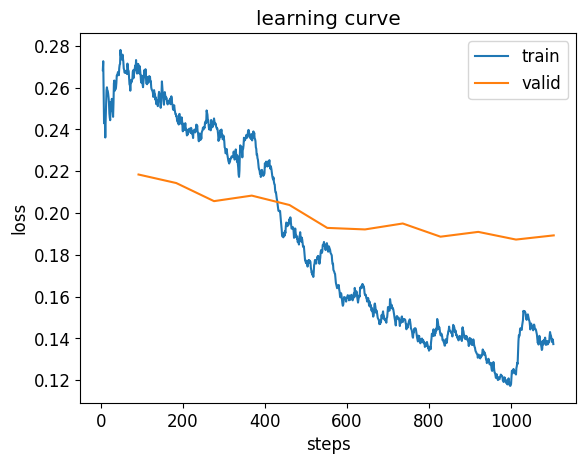

In [33]:
learn.recorder.plot_loss()

Now that we have a good learning rate, let's see hwo we can fine-tune the weights of a pre-trained model.

### Selecting the Number of Epochs

When choosing the right amount of epochs, time is usually constraint rather than generalization and accuracy

So usually we pick number of epochs we're happy to wait for, then look at training and validation loss plots and see that they are still getting better in final epochs

Sometimes, metrics might get worse at end of training

The validation loss will first get wrose during raining because the model gets overonfidnet, and only later will get worse because it is incorrectly memorizing data

We only care about the latter issue

Our loss function is what we use to allow our optimizer to have something it can differentiate and optimize

Early stopping is a way to save the model after every epoch and choose the one with the best accuracy out of all models 

This is unlikely to give best result since the learning rates are not small enough where it can really find the best result

Therefore, when we have overfit data we should start from scratch and select a total number of epochs based on where the prvious best resutls were found

If there is time for more epochs, maybe we could use more parameters = a deeper architecture

### Deeper Architectures

In general more parameters means more accurate modelling data

A bigger model has ability to capture real underlying relationships in data, but also to capture and memorize specific details of our individual images

A bigger model also takes longer to train:
- One way to speed things up is mixed-precision training
    - Using less-precise numbers where possible during training

Tip: add to_fp16() after Learner creation to use tensor cores on NVIDIA GPUs


In [34]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

/home/one6ix/Desktop/fastai/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/one6ix/Desktop/fastai/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,2.188262,0.486542,0.148173,00:13
1,0.869610,0.332397,0.102165,00:13
2,0.543221,0.311130,0.094723,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.275608,0.227898,0.066306,00:15
1,0.245040,0.222209,0.067659,00:15
2,0.219919,0.200790,0.065629,00:15
3,0.145136,0.201783,0.064276,00:14
4,0.085315,0.181473,0.052774,00:14
5,0.059253,0.179889,0.054804,00:15


We've gone back to using fine_tine since its so handy

We can pass freeze_epochs to tell fastai how many epochs to train for while frozen (this automatically cahnges learning rates appropriately for morst datasets)

There's no clear winner (bigger models aren't necessarily better for our particular case)

## Conclusion

In this chapter you learned some important practical tips, both for getting your image data ready for modeling (presizing, data block summary) and for fitting the model (learning rate finder, unfreezing, discriminative learning rates, setting the number of epochs, and using deeper architectures). Using these tools will help you to build more accurate image models, more quickly.

We also discussed cross-entropy loss. This part of the book is worth spending plenty of time on. You aren't likely to need to actually implement cross-entropy loss from scratch yourself in practice, but it's really important you understand the inputs to and output from that function, because it (or a variant of it, as we'll see in the next chapter) is used in nearly every classification model. So when you want to debug a model, or put a model in production, or improve the accuracy of a model, you're going to need to be able to look at its activations and loss, and understand what's going on, and why. You can't do that properly if you don't understand your loss function.

If cross-entropy loss hasn't "clicked" for you just yet, don't worry—you'll get there! First, go back to the last chapter and make sure you really understand `mnist_loss`. Then work gradually through the cells of the notebook for this chapter, where we step through each piece of cross-entropy loss. Make sure you understand what each calculation is doing, and why. Try creating some small tensors yourself and pass them into the functions, to see what they return.

Remember: the choices made in the implementation of cross-entropy loss are not the only possible choices that could have been made. Just like when we looked at regression we could choose between mean squared error and mean absolute difference (L1). If you have other ideas for possible functions that you think might work, feel free to give them a try in this chapter's notebook! (Fair warning though: you'll probably find that the model will be slower to train, and less accurate. That's because the gradient of cross-entropy loss is proportional to the difference between the activation and the target, so SGD always gets a nicely scaled step for the weights.)